### **Projeto: Detecção de fraude em cartão de crédito**


---


Tradução e adaptação do código: Rodrigo da Costa Aglinskas

Projeto: Detecção de fraude em cartão de crédito

Desafio de projeto: Análise em Python com uso da biblioteca Pandas - DIO

Iniciado em 11/09/2021



### **Importando arquivos e bibliotecas**

In [83]:
# Importando as bibliotecas:

import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("seaborn")
%matplotlib inline

from matplotlib.patches import Rectangle
import numpy as np
from pprint import pprint as pp
import csv
from pathlib import Path
import seaborn as sns
from itertools import product
import string

import six
import sys
sys.modules['sklearn.externals.six'] = six

import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.pipeline import Pipeline 

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import r2_score, classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
from sklearn.metrics import homogeneity_score, silhouette_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import MiniBatchKMeans, DBSCAN

import gensim
from gensim import corpora

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [84]:
# Configuração Pandas:

pd.set_option('display.max_columns', 700)
pd.set_option('display.max_rows', 400)
pd.set_option('display.min_rows', 10)
pd.set_option('display.expand_frame_repr', True)

In [85]:
# Leitura de arquivos:

cc1_file = 'creditcard_sampledata.csv'
# cc1_file = 'creditcard_fraud.csv'

banksim_file = 'banksim.csv'
banksim_adj_file = 'banksim_adj.csv'
# arquivos pickle:
db_full_file = 'db_full.pickle'
labels_file = 'labels.pickle'
labels_full_file = 'labels_full.pickle'
x_scaled_file = 'x_scaled.pickle'
x_scaled_full_file = 'x_scaled_full.pickle'

enron_emails_clean_file = 'enron_emails_clean.csv'
# arquivos pickle:
cleantext_file = 'cleantext.pickle'
corpus_file = 'corpus.pickle'
dict_file = 'dict.pickle'
ldamodel_file = 'ldamodel.pickle'


### **Verificando a relação fraude x não fraude**

In [86]:
df = pd.read_csv(cc1_file)

In [87]:
# Verificando a estrutura do dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 32 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  8000 non-null   int64  
 1   Time        8000 non-null   int64  
 2   V1          8000 non-null   float64
 3   V2          8000 non-null   float64
 4   V3          8000 non-null   float64
 5   V4          8000 non-null   float64
 6   V5          8000 non-null   float64
 7   V6          8000 non-null   float64
 8   V7          8000 non-null   float64
 9   V8          8000 non-null   float64
 10  V9          8000 non-null   float64
 11  V10         8000 non-null   float64
 12  V11         8000 non-null   float64
 13  V12         8000 non-null   float64
 14  V13         8000 non-null   float64
 15  V14         8000 non-null   float64
 16  V15         8000 non-null   float64
 17  V16         8000 non-null   float64
 18  V17         8000 non-null   float64
 19  V18         8000 non-null  

In [88]:
df["V4"] = pd.to_numeric(df["V4"], downcast="float")

In [89]:
df.dtypes

Unnamed: 0      int64
Time            int64
V1            float64
V2            float64
V3            float64
V4            float32
V5            float64
V6            float64
V7            float64
V8            float64
V9            float64
V10           float64
V11           float64
V12           float64
V13           float64
V14           float64
V15           float64
V16           float64
V17           float64
V18           float64
V19           float64
V20           float64
V21           float64
V22           float64
V23           float64
V24           float64
V25           float64
V26           float64
V27           float64
V28           float64
Amount        float64
Class           int64
dtype: object

In [90]:
df.head()

,Unnamed: 0,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,64,1.212511,-0.099054,-1.192094,0.286324,2.160516,3.616314,-0.404207,0.842331,0.169360,-0.030522,-0.541957,0.237212,-0.218130,0.197437,-0.147850,-0.097830,-0.510053,-0.070939,0.355171,0.014777,-0.167496,-0.494695,-0.149785,1.011227,0.883548,-0.329434,0.020370,0.017037,34.70,0
1,1,64,-0.658305,0.406791,2.037461,-0.291298,0.147910,-0.350857,0.945373,-0.172560,0.025133,-0.778135,-0.196290,0.632955,0.374025,-0.531597,-0.615063,-0.518078,0.003881,-1.288954,-0.797804,0.064133,-0.156096,-0.238805,0.089877,0.421195,-0.352487,0.074783,-0.094192,-0.092493,54.99,0
2,2,124,1.105253,0.541842,0.839421,2.570933,-0.279517,-0.423062,0.088019,0.011622,-0.715756,0.651379,0.073787,-0.142024,-0.739457,0.502639,0.736688,0.256745,-0.093732,-1.011416,-1.465500,-0.239883,-0.137434,-0.460991,0.189397,0.556329,0.185786,-0.189030,0.000208,0.026167,6.24,0
3,3,128,1.239495,-0.182609,0.155058,-0.928892,-0.746227,-1.235608,-0.061695,-0.125223,0.984938,-0.746625,1.563459,0.890132,-0.985159,0.778734,1.016974,-0.429490,-0.335787,0.614690,0.703133,-0.160406,0.146077,0.481119,-0.140019,0.538261,0.710720,-0.621382,0.036867,0.010963,8.80,0
4,4,132,-1.571359,1.687508,0.734670,1.293350,-0.217532,-0.002677,0.147364,0.515362,-0.372442,0.078021,-0.592495,0.997941,1.109328,0.060048,0.086141,-1.149893,0.765198,-0.810589,0.737550,-0.093614,0.048549,0.377256,-0.030436,0.117608,-0.060520,-0.296550,-0.481570,-0.167897,10.00,0


In [91]:
df.tail()

,Unnamed: 0,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
7995,7995,172582,-0.942732,0.763164,0.185440,-0.064400,0.519435,-0.824899,0.837716,-0.210690,0.751164,-0.018101,-1.282571,-0.083814,-0.648833,0.032064,-0.235620,-1.311480,0.207468,-0.041811,0.900936,0.020565,0.190588,1.079226,-0.199087,-0.045535,0.181797,-0.293424,0.285188,0.393999,10.00,0
7996,7996,172599,-0.195044,1.238305,-0.768720,-0.178302,0.582600,-1.282570,0.946855,-0.129767,-0.040571,-0.915827,-0.700535,-0.463585,-0.424763,-0.708648,0.713934,0.029515,0.617882,0.766489,-0.185751,-0.205106,0.365673,1.207021,-0.111128,-0.162594,-0.896012,-0.259841,-0.131265,-0.005010,18.16,0
7997,7997,172617,2.038001,-0.089042,-2.260703,0.095598,0.697565,-1.111463,0.734825,-0.482797,0.017646,0.176691,-0.918823,0.020991,0.035599,0.707151,0.353104,-0.216797,-0.424495,-0.562745,0.108726,-0.055889,0.084980,0.173524,-0.014877,0.543928,0.249404,0.705467,-0.141402,-0.067495,66.30,0
7998,7998,172726,-0.484304,0.035673,-0.151704,-2.219867,-0.664752,0.790599,-0.794190,-1.702391,-2.018426,1.810499,0.228083,-0.306278,0.895626,-0.439779,-0.725171,-0.802003,0.481581,0.792651,1.152540,-0.705632,1.631565,0.317559,0.163274,0.227622,-1.011773,-0.094912,0.019251,0.233020,68.00,0
7999,7999,172766,1.975178,-0.616244,-2.628295,-0.406246,2.327804,3.664740,-0.533297,0.842937,1.128798,-0.220744,-0.590756,0.654596,-0.479779,0.120626,-0.907042,-1.186261,0.146953,-0.681104,0.295402,-0.168378,0.086043,0.543613,-0.032129,0.768379,0.477688,-0.031833,0.014151,-0.066542,25.00,0


In [92]:
# Conta ocorrências de fraude and não fraude e imprime:

occ = df['Class'].value_counts()
occ

0    7983
1      17
Name: Class, dtype: int64

In [93]:
# Imprime a Razão de casos de fraude em relação ao total:

ratio_cases = occ/len(df.index)
print(f'Razão de ocorrências de fraude: {ratio_cases[1]}\nRazão de ocorrências não fraudulentas: {ratio_cases[0]}')

Razão de ocorrências de fraude: 0.002125
Razão de ocorrências não fraudulentas: 0.997875


### **Visualização de dados**

In [ ]:
# função preparando o df

def prep_data(df: pd.DataFrame) -> (np.ndarray, np.ndarray):
    """
    Convert the DataFrame into two variable
    X: data columns (V1 - V28)
    y: lable column
    """
    X = df.iloc[:, 1:29].values
    y = df.Class.values
    return X, y

In [ ]:
# Função cria um scatter plot dos dados e etiquetas
def plot_data(X: np.ndarray, y: np.ndarray):
    plt.scatter(X[y == 0, 0], X[y == 0, 1], label="Class #0", alpha=0.5, linewidth=0.15)
    plt.scatter(X[y == 1, 0], X[y == 1, 1], label="Class #1", alpha=0.5, linewidth=0.15, c='r')
    plt.legend()
    return plt.show()

In [ ]:
# Cria X e y da função prep_data
X, y = prep_data(df)

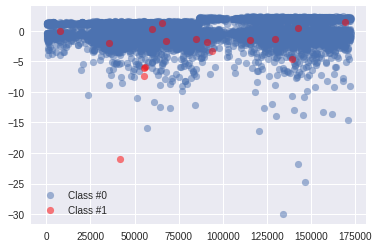

In [97]:
# Gerando gráfico dos dados pela função plot data em X and y
plot_data(X, y)

### **Aumente as detecções bem-sucedidas com a reamostragem de dados**

In [98]:
# Undersampling  x Oversampling

# Implementando métodos de reamostragem usando o módulo Python imblean 

from imblearn.over_sampling import RandomOverSampler



# Define o método de reamostragem em treino e teste
method = SMOTE(kind='borderline1')
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)

# Aplica a reamostragem apenas aos dados de treinamento 
X_resampled, y_resampled = method.fit_sample(X_train, y_train)

# Ajusta o modelo e obtém previsões
model = LogisticRegression()
model.fit(X_resampled, y_resampled)

# Obtem métricas de desempenho do modelo
predicted = model.predict(X_test)
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1594
           1       1.00      0.17      0.29         6

    accuracy                           1.00      1600
   macro avg       1.00      0.58      0.64      1600
weighted avg       1.00      1.00      1.00      1600



In [99]:
# Métodos de reamostragem para dados desequilibrados
# Aplicando o Synthetic Minority Oversampling Technique (SMOTE)

# Executando a função prep_data
X, y = prep_data(df)

In [100]:
print(f'X shape: {X.shape}\ny shape: {y.shape}')

X shape: (8000, 28)
y shape: (8000,)


In [101]:
# Definindo o método de reamostragem
method = SMOTE()

In [102]:
# Cria um conjunto de recursos reamostrado 
X_resampled, y_resampled = method.fit_sample(X, y)

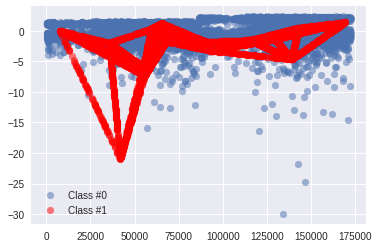

In [103]:
# Plotando os dados reamostrados 
plot_data(X_resampled, y_resampled)

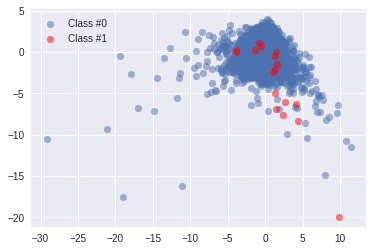

In [104]:
# Reproduzido usando o DataFrame
plt.scatter(df.V2[df.Class == 0], df.V3[df.Class == 0], label="Class #0", alpha=0.5, linewidth=0.15)
plt.scatter(df.V2[df.Class == 1], df.V3[df.Class == 1], label="Class #1", alpha=0.5, linewidth=0.15, c='r')
plt.legend()
plt.show()

In [105]:
#Compare SMOTE to original data

pd.value_counts(pd.Series(y))

0    7983
1      17
dtype: int64

In [106]:
pd.value_counts(pd.Series(y_resampled))



1    7983
0    7983
dtype: int64

In [107]:
# Função compara o df original com o de reamostragem:

def compare_plot(X: np.ndarray, y: np.ndarray, X_resampled: np.ndarray, y_resampled: np.ndarray, method: str):
    plt.subplot(1, 2, 1)
    plt.scatter(X[y == 0, 0], X[y == 0, 1], label="Class #0", alpha=0.5, linewidth=0.15)
    plt.scatter(X[y == 1, 0], X[y == 1, 1], label="Class #1", alpha=0.5, linewidth=0.15, c='r')
    plt.title('Original Set')
    plt.subplot(1, 2, 2)
    plt.scatter(X_resampled[y_resampled == 0, 0], X_resampled[y_resampled == 0, 1], label="Class #0", alpha=0.5, linewidth=0.15)
    plt.scatter(X_resampled[y_resampled == 1, 0], X_resampled[y_resampled == 1, 1], label="Class #1", alpha=0.5, linewidth=0.15, c='r')
    plt.title(method)
    plt.legend()
    plt.show()

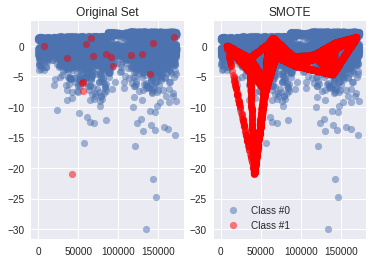

In [108]:
compare_plot(X, y, X_resampled, y_resampled, method='SMOTE')

### **Fraud detection algorithms in action**

In [109]:
# Sistemas baseados em Machine Learning

# 1: divide os recursos e rótulos em dados de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
clf = LinearRegression().fit(X_train, y_train)

In [111]:
# 2: Define o modelo a usar
model = LinearRegression()

In [112]:
# 3: Ajusta o modelo aos dados de treino
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [113]:
# 4: Obtém o modelo preditivo para os dados de teste
y_predicted = model.predict(X_test)

In [114]:
# 5: Compare y_test to predictions and obtain performance metrics (r^2 score)
r2_score(y_test, y_predicted)

0.3120535831886888

In [115]:
# Exploring the traditional method of fraud detection

df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [116]:
df.groupby('Class').mean()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
Class,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,95383.605161,0.023553,-0.008543,-0.002408,-0.034757,-0.020108,0.003264,0.023668,-0.004720,-0.010660,0.012242,0.005628,0.007979,-0.003281,0.018215,-0.012515,-0.000099,0.005028,0.002325,-0.012212,-0.00692,-0.004279,0.027999,0.006689,-0.000550,-0.000616,0.000659,-0.006740,0.005625,89.721167
1,83000.176471,-3.235382,1.317054,-3.762234,2.801140,-0.941354,-1.184692,-3.527826,-0.108892,-1.546536,-4.112638,2.697962,-4.649967,-0.597431,-5.104228,-0.137424,-3.176719,-5.237885,-1.630226,0.428150,-0.29245,0.361582,0.159210,-0.119366,-0.144082,0.155552,0.038765,0.265996,0.131853,65.287647


In [117]:
df['flag_as_fraud'] = np.where(np.logical_and(df.V1 < -3, df.V3 < -5), 1, 0)

### **Referências:**

https://www.teses.usp.br/teses/disponiveis/45/45134/tde-01022016-204144/publico/Paulo_Oliveira_Mestrado_PPGCC.pdf

https://towardsdatascience.com/understand-and-build-fp-growth-algorithm-in-python-d8b989bab342

https://trenton3983.github.io/files/projects/2019-07-19_fraud_detection_python/2019-07-19_fraud_detection_python.html

people described by a set of attributes as good or bad credit risks.
https://www.openml.org/d/31

creditcard fraud  in September 2013 by european cardholders
https://www.openml.org/d/42175
https://www.openml.org/d/1597